# TrainFinalModel
Important: Use Python 3.8, not 3.10! Prophet is not compatible with 3.8 :(

In [1]:
import math
from datetime import datetime
from datetime import timedelta
import pandas as pd
from pathlib import Path
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.utilities import regressor_coefficients
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot as plt
from prophet.serialize import model_to_json, model_from_json
import math

/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Switzerland
COVID_START = datetime(2020, 3, 1).date()
# https://www.admin.ch/gov/en/start/documentation/media-releases.msg-id-84127.html
# date taken as the second easing of restrictions during 2021
COVID_END = datetime(2021, 6, 1).date()

MODEL_PATH = Path("../data/model/")
TRAIN_DATA_PATH = Path('../data/consumption/final_train.parquet')

MODEL_NAME = "totalconsumption_rolling7day.json"
CONSUMPTION_EXPR = "NE5Consumption + NE7Consumption" # i.e. "NE5Consumption + NE7Consumption", "NE5Consumption", "NE7Consumption"
ROLLING_WINDOW = 7
CONFIDENCE_INTERVAL = 0.95
USE_WEEK_SEASONALITY = False
USE_HOLIDAYS = False

In [3]:
"""
    return (spark.read.format("parquet").load(path)
                                      .withColumn("y", f.expr(CONSUMPTION_EXPR))
                                      .withColumn("CosYearTemp", f.expr("Temperature * cos(dayofyear(Date) * 2 * pi() / 365)"))
                                      .withColumn("SinYearTemp", f.expr("Temperature * sin(dayofyear(Date) * 2 * pi() / 365)"))
                                      .selectExpr("Date as ds", "y", "CosYearTemp", "SinYearTemp")
                                      .orderBy("ds")
         ).toPandas().rolling(ROLLING_WINDOW, on="ds").mean().dropna()[:-ROLLING_WINDOW]
"""

train = pd.read_parquet(TRAIN_DATA_PATH, engine='pyarrow')
train['Date'] = pd.to_datetime(train['Date'])
train['y'] = train['NE5Consumption'] + train['NE7Consumption']
train['CosYearTemp'] = train.apply(lambda row: row['Temperature'] * math.cos(row['Date'].dayofyear * 2 * math.pi / 365), axis=1)
train['SinYearTemp'] = train.apply(lambda row: row['Temperature'] * math.sin(row['Date'].dayofyear * 2 * math.pi / 365), axis=1)
train.rename(columns={'Date': 'ds'}, inplace=True)
train = train.sort_values('ds')
train = train.rolling(ROLLING_WINDOW, on='ds').mean().dropna()[:-ROLLING_WINDOW]

train.head()

,ds,CosYearTemp,NE5Consumption,NE7Consumption,SinYearTemp,Temperature,y
6,2010-01-07,-3.159030,2.258346e+06,6.117821e+06,-0.263060,-3.170238,8.376166e+06
7,2010-01-08,-3.853628,2.369737e+06,6.369915e+06,-0.312660,-3.867857,8.739652e+06
8,2010-01-09,-4.192654,2.400751e+06,6.462223e+06,-0.400371,-4.214286,8.862974e+06
9,2010-01-10,-4.124035,2.409404e+06,6.500179e+06,-0.473630,-4.154167,8.909584e+06
10,2010-01-11,-3.781718,2.428986e+06,6.527268e+06,-0.525976,-3.820833,8.956253e+06


In [4]:
# add covid as a one-off holiday
covid = pd.DataFrame([
    {'holiday': 'covid', 'ds': COVID_START, 'lower_window': 0, 'ds_upper': COVID_END}
])

covid['upper_window'] = (covid['ds_upper'] - covid['ds']).dt.days

In [5]:
m = Prophet(holidays = covid, weekly_seasonality = USE_WEEK_SEASONALITY, changepoint_prior_scale = 0.005, changepoint_range=1, interval_width=CONFIDENCE_INTERVAL, uncertainty_samples = 10000)

if USE_HOLIDAYS:
    m.add_country_holidays(country_name='CH')
  
m.add_regressor("CosYearTemp", prior_scale = 0.05, standardize = True, mode = "additive")
m.add_regressor("SinYearTemp", prior_scale = 0.05, standardize = True, mode = "additive")
m.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.7443


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       15266.3   0.000907129       3466.64      0.4215      0.4215      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       15333.5    0.00442594       6572.05      0.3827      0.3827      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       15358.5    0.00011362       1160.51   1.196e-07       0.001      361  LS failed, Hessian reset 
     299       15359.2   5.23156e-05       918.717      0.8185      0.8185      385   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323       15359.8   0.000343061       3037.12   3.646e-07       0.001      459  LS failed, Hessian reset 
     399       15360.5   1.47938e-06       651.514      0.1956      0.1956      572   
    Iter      log prob        ||dx||      ||grad||       alpha

In [6]:
forecastTrain = m.predict(train)

/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/for

/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


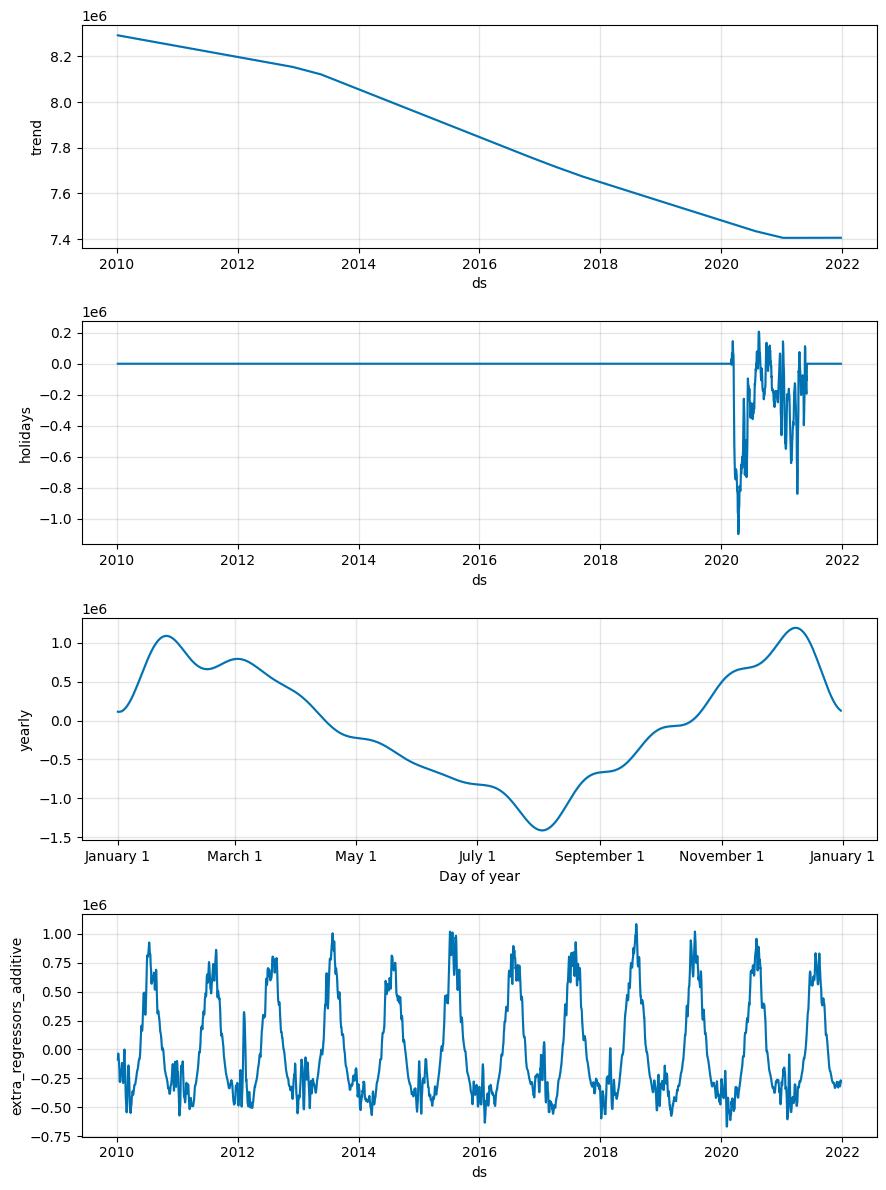

In [7]:
fig = m.plot_components(forecastTrain)

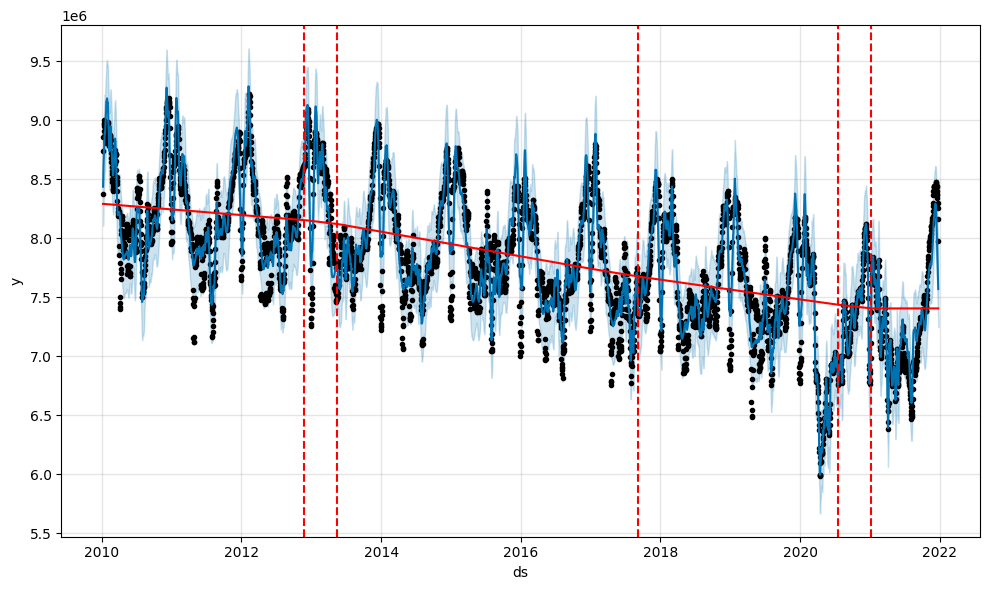

In [8]:
fig = m.plot(forecastTrain)
a = add_changepoints_to_plot(fig.gca(), m, forecastTrain)

In [9]:
mse = mean_squared_error(train["y"].to_numpy(), forecastTrain["yhat"].to_numpy())
mse

27128986813.784115

In [10]:
rmse = math.sqrt(mse)
rmse

164708.79397829404

In [11]:
mean_absolute_percentage_error(train["y"].to_numpy(), forecastTrain["yhat"].to_numpy())

0.014946178674369261

In [12]:
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,CosYearTemp,additive,-4.510686,-47068.633763,-47068.633763,-47068.633763
1,SinYearTemp,additive,-1.329717,-20845.607552,-20845.607552,-20845.607552


In [13]:
plotData = pd.DataFrame(
  {
    "Actual": train["y"].array,
    "PredictedMean": forecastTrain["yhat"].array,
    "PredictedHigh": forecastTrain["yhat_upper"].array,
    "PredictedLow": forecastTrain["yhat_lower"].array
  },
  index=train["ds"]
)

plotData.index = pd.to_datetime(plotData.index)
plotData = plotData.sort_index()

In [14]:
def plot(data):
  fig, ax = plt.subplots()
  fig.set_size_inches(12, 8)
  fig.patch.set_facecolor('white')
  ax.plot(data.index, data["Actual"])
  ax.fill_between(data.index, data["PredictedHigh"], data["PredictedLow"], color='orange', alpha=.2)

In [19]:
plotData.head()

,Actual,PredictedMean,PredictedHigh,PredictedLow
ds,,,,
2010-01-07,8.376166e+06,8.437576e+06,8.763433e+06,8.106246e+06
2010-01-08,8.739652e+06,8.518364e+06,8.845113e+06,8.194164e+06
2010-01-09,8.862974e+06,8.589074e+06,8.913292e+06,8.273583e+06
2010-01-10,8.909584e+06,8.645094e+06,8.971046e+06,8.323254e+06
2010-01-11,8.956253e+06,8.691453e+06,9.015895e+06,8.361033e+06


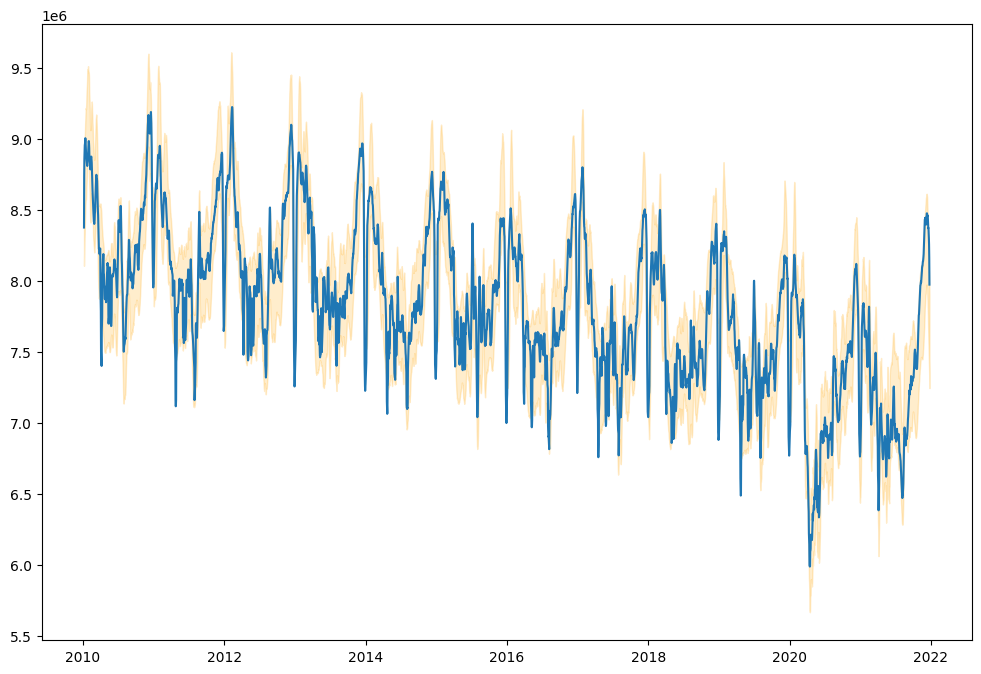

In [15]:
plot(plotData)

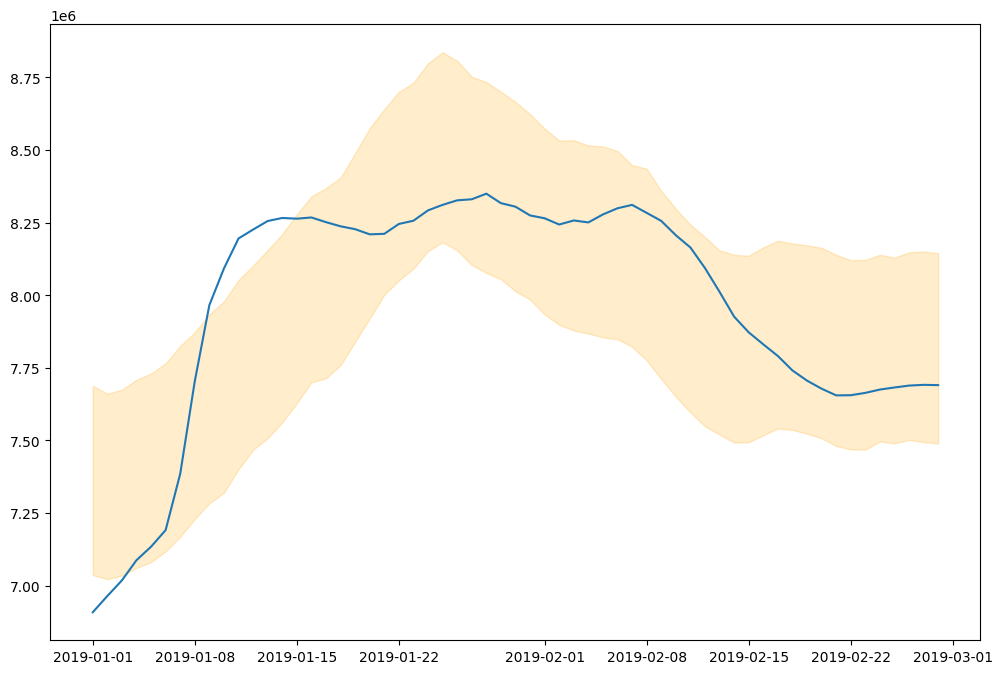

In [16]:
plot(plotData[(plotData.index >= datetime(2019, 1, 1)) & (plotData.index < datetime(2019, 3, 1))])

In [18]:
with open(MODEL_PATH / MODEL_NAME, 'w') as fout:
    fout.write(model_to_json(m))